<a href="https://colab.research.google.com/github/d8vela/colabseq/blob/main/ColabSeq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

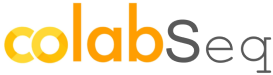

The one-stop shop for all of your multiple sequence analysis needs.

# <font color="orange"> **Setup Requirements** </font>

In [1]:
# See https://logomaker.readthedocs.io/en/latest/
!pip install biopython
!pip install logomaker

In [2]:
import logomaker
import math
import os
import re
import matplotlib
import tempfile
import warnings
import IPython

import pandas as pd
import matplotlib.pyplot as plt

from google.colab import files
from tqdm import tqdm
from Bio import SeqIO, AlignIO, Phylo
from Bio.Align import AlignInfo, MultipleSeqAlignment
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from IPython.display import HTML, Image


In [3]:
#@title Core Functions
def input_str_to_dict(input_str):
    # Convert input_str to input_dict
    input_dict = {}

    if '>' in input_str:
        # FASTA format
        for line in input_str.split('\n'):
            if line:
                if line[0] == '>':
                    # Split by pipeline (if one or more exist)
                    full_id = line.split('|')
                    # Get first element of ID and skip '>' character
                    id = full_id[0][1:]
                    input_dict[id] = ''
                else:
                    seq = line
                    input_dict[id] += seq
    else:
        # Tab deliminiated format
        for line in input_str.split('\n'):
            if line:
                id, seq = line.split()
                input_dict[id] = seq

    return input_dict


def generate_seqs (seqs_dict):
    # Generate list of sequence records
    seqs = []
    for id, seq in seqs_dict.items():
        seq = SeqRecord(id=id, seq=Seq(seq), description='')
        seqs.append(seq)

    return seqs


def generate_msa (seqs, input_file='seq.fasta', output_file='msa.fasta'):
    # The quick and easy one-off MSA generator

    # Needs:
    # import tempfile, os
    # from Bio import SeqIO, AlignIO

    # Define download URL
    download_url = 'https://github.com/rcedgar/muscle/releases/download/5.1.0/muscle5.1.linux_intel64'

    # Get current working directory
    cwd = os.getcwd()

    # Download MUSCLE v5 executable for linux (64-bit) to the current working directory
    if not os.path.exists("muscle"):
        wget_stdout = !wget $download_url -O muscle &>/dev/null
        chmod_stdout = !chmod +x muscle &>/dev/null

    # Define path to muscle executable
    muscle_path = f'{cwd}/muscle'

    with tempfile.TemporaryDirectory() as temp_dir:

        # Write out input file
        SeqIO.write(seqs, f'{temp_dir}/{input_file}', 'fasta')

        # Define and run command line
        cline = f'{muscle_path} -super5 {temp_dir}/{input_file} -output {temp_dir}/{output_file}'
        muscle_stdout = !$cline

        # Copy output MSA file to the current directory so we can download it later
        !cp $temp_dir/$output_file $cwd

        # Read MSA otuput into Bio.AlignIO MSA object
        msa = AlignIO.read(f'{temp_dir}/{output_file}', format='fasta')

        return msa, output_file


def color_msa_by_chemical_composition(msa):

    # make dictionary of amino acids colored by amino acid type
    aa_color = {
        'A': 'yellow',
        'C': 'yellow',
        'D': 'red',
        'E': 'red',
        'F': 'yellow',
        'G': 'lime',
        'H': 'cyan',
        'I': 'yellow',
        'K': 'cyan',
        'L': 'yellow',
        'M': 'yellow',
        'N': 'orange',
        'P': 'yellow',
        'Q': 'orange',
        'R': 'cyan',
        'S': 'orange',
        'T': 'orange',
        'V': 'yellow',
        'W': 'yellow',
        'Y': 'yellow',
        '-': 'white',
        'X': 'grey',
    }

    html = "<table>"
    for record in msa:
        html += "<tr>"
        html += f"<td><b>{record.id}</b></td><td><b>:</b></td><td></td><td></td><td></td>"
        for aa in record.seq:
            # percentage = 1
            color = aa_color[aa]
            html += f"<td ALIGN=CENTER><font color='{color}'>{aa}</font></td>"
        html += "</tr>"
    html += "</table>"

    return html


def generate_phylo_tree(msa_input_file='msa.fasta', tree_output_file='msa.tree'):
    # The quick and easy one-off Phylogenetic Tree generator

    # Needs:
    # import tempfile, os

    # Define download URL
    download_url = 'https://github.com/amkozlov/raxml-ng/releases/download/1.2.0/raxml-ng_v1.2.0_linux_x86_64.zip'

    # Download RAxML NextGen
    if not os.path.exists("raxml-ng_v1.2.0_linux_x86_64.zip"):
        stdout_wget = !wget $download_url &>/dev/null
        stdout_unzip = !unzip raxml-ng_v1.2.0_linux_x86_64.zip &>/dev/null

    # Get current working directory
    cwd = os.getcwd()

    # Define patht to RAxML executable
    raxml_path = f'{cwd}/raxml-ng'

    with tempfile.TemporaryDirectory() as temp_dir:
        # Run RAxML NextGen
        # Use --search1 for quick and dirty setting
        # Use --all for running tree search, optimization and bootstrapping
        # See https://isu-molphyl.github.io/EEOB563/computer_labs/lab4/raxml-ng.html
        # for more information of all the options
        !cp $cwd/$msa_input_file $temp_dir &>/dev/null
        !$raxml_path --search1 --msa $temp_dir/$msa_input_file --model LG+G8+F &>/dev/null

        # Copy the newick file for the best tree to the current working directory
        base_file = os.path.basename(msa_input_file)
        raxml_tree_file = f'{base_file}.raxml.bestTree'
        !cp $temp_dir/$raxml_tree_file $cwd/$tree_output_file &>/dev/null

    return tree_output_file


def substract_df(val, df):
    # Make copy of the dataframe
    df_copy = df.copy(deep=True)

    # Iterate over each matrix element in dataframe
    for idx in df_copy.index:
        for char in list(df_copy.columns):
            # Substract val with matrix element
            new_val = val - df_copy.loc[idx][char]
            # Update dataframe
            df_copy.loc[idx][char] = new_val

    return df_copy


def src_from_data(data):
    """Base64 encodes image bytes for inclusion in an HTML img element"""
    img_obj = Image(data=data)
    for bundle in img_obj._repr_mimebundle_():
        for mimetype, b64value in bundle.items():
            if mimetype.startswith('image/'):
                return f'data:{mimetype};base64,{b64value}'


def color_msa_seqlogo(msa, logo_dir='logo'):

    # make dictionary of amino acids colored by amino acid type
    aa_color = {
        'A': 'yellow',
        'C': 'yellow',
        'D': 'red',
        'E': 'red',
        'F': 'yellow',
        'G': 'lime',
        'H': 'cyan',
        'I': 'yellow',
        'K': 'cyan',
        'L': 'yellow',
        'M': 'yellow',
        'N': 'orange',
        'P': 'yellow',
        'Q': 'orange',
        'R': 'cyan',
        'S': 'orange',
        'T': 'orange',
        'V': 'yellow',
        'W': 'yellow',
        'Y': 'yellow',
        '-': 'white',
        'X': 'grey',
    }

    html = "<table>"

    html += "<tr><td></td><td></td>"

    # Output Y Axis (bits)
    with open(f'{logo_dir}/axis.png', 'rb') as f:
        logo_buffer = f.read()
        src = src_from_data(logo_buffer)
        logo_html = f'<image src="{src}">'
        html += f"<td VALIGN=BOTTOM>{logo_html}</td>"

    html += "<td></td><td></td>"

    for idx in range(msa.get_alignment_length()):
        with open(f'{logo_dir}/{idx}.png', 'rb') as f:
            logo_buffer = f.read()
            src = src_from_data(logo_buffer)
            logo_html = f'<image src="{src}">'
            html += f"<td>{logo_html}</td>"

    html += "</tr>"

    for record in msa:
        html += "<tr>"
        html += f"<td><b>{record.id}</b></td><td><b>:</b></td><td></td><td></td><td></td>"
        for aa in record.seq:
            # percentage = 1
            color = aa_color[aa]
            html += f"<td><center><font color='{color}'>{aa}</font></center></td>"
        html += "</tr>"
    html += "</table>"

    return html


def chop_tree(file_object):
    # Chop a ASCII phylogenetic tree into branches and leaf sequence IDs

    # Find make list of "leaf" sequence IDs and find max branch length
    seq_ids = []
    max_line = 0
    for line in file_object.readlines():
        seq_id = re.search(r'_ (\S+)$', line)
        if seq_id:
            seq_ids.append(seq_id.group(1))
        line = re.sub(r'_ \S+$', '_', line)
        line_length = len(line)
        if line_length > max_line:
            max_line = line_length

    # Chop phylogenetic tree into a list of branches
    branches = []
    file_object.seek(0)
    for line in file_object.readlines():
        line = re.sub(r'_ \S+$', '_', line)
        line_length = len(line)
        line_extend = '_' * (max_line - line_length)
        if re.match(r'.*_$', line):
            line = re.sub(r'_$', line_extend, line)
        branches.append(line)

    return branches, seq_ids


def output_rebuilt_tree(branches, seq_ids):
    # Rebuild and output phylogenetic tree from list of branches and sequence IDs
    idx = 0
    for stick in branches:
        stick = stick.strip('\n')
        if re.match(r'.*_$', stick):
            print(stick, seq_ids[idx], '\n', end='')
            idx += 1
        else:
            print(stick, '\n', end='')


def html_rebuilt_tree(branches, seq_ids):
    # Rebuild and output phylogenetic tree from list of branches and sequence IDs
    idx = 0
    html = '<tt><table>'
    for stick in branches:
        stick = stick.strip('\n')
        html += "<tr>"
        if re.match(r'.*_$', stick):
            html += f'<td>{stick}</td><td>{seq_ids[idx]}</td>'
            html = re.sub(r' ', '&nbsp;', html)
            idx += 1
        else:
            html += f'<td>{stick}</td>\n'
            html = re.sub(r' ', '&nbsp;', html)
        html += "</tr>"
    html += "</table></tt>"

    return html


def color_msa_seqlogo_phylotree(msa, branches, seq_ids, logo_dir='logo'):

    # Make dictionary of amino acids colored by amino acid type
    aa_color = {
        'A': 'yellow',
        'C': 'yellow',
        'D': 'red',
        'E': 'red',
        'F': 'yellow',
        'G': 'lime',
        'H': 'cyan',
        'I': 'yellow',
        'K': 'cyan',
        'L': 'yellow',
        'M': 'yellow',
        'N': 'orange',
        'P': 'yellow',
        'Q': 'orange',
        'R': 'cyan',
        'S': 'orange',
        'T': 'orange',
        'V': 'yellow',
        'W': 'yellow',
        'Y': 'yellow',
        '-': 'white',
        'X': 'grey',
    }

    # Start the HTML table
    html = "<table border=0>"

    html += "<tr><td></td><td></td><td></td>"

    # Output Y Axis (bits)
    with open(f'{logo_dir}/axis.png', 'rb') as f:
        logo_buffer = f.read()
        src = src_from_data(logo_buffer)
        logo_html = f'<image src="{src}">'
        html += f"<td COLSPAN=2 VALIGN=BOTTOM ALIGN=RIGHT>{logo_html}</td>"

    # Output SeqLogos
    for idx in range(msa.get_alignment_length()):
        with open(f'{logo_dir}/{idx}.png', 'rb') as f:
            logo_buffer = f.read()
            src = src_from_data(logo_buffer)
            logo_html = f'<image src="{src}">'
            html += f"<td VALIGN=BOTTOM>{logo_html}</td>"

    html += "</tr>"

    # Output Phylogenetic Tree connected to the colored MSA
    msa_dict = {i.id: i.seq for i in msa}

    idx = 0
    for stick in branches:
        html += "<tr>"

        if re.match(r'.*_$', stick):
            # Output stick of the tree branch
            stick = re.sub(r' ', '&nbsp;', stick)
            html += f'<td><tt>{stick}</tt></td>'
            html += "<td></td><td></td>"

            # Output "leaf" sequence ID (10 character limit)
            seq = msa_dict[seq_ids[idx]]
            html += f"<td COLSPAN=2><tt><b>{seq_ids[idx][:10]}&nbsp;:&nbsp;</b></tt></td>"

            # Output colored sequence alignment
            for aa in seq:
                color = aa_color[aa]
                html += f"<td><center><font color='{color}'>{aa}</font></center></td>"

            # Increment index for "leave" sequence ID
            idx += 1
        else:
            stick = re.sub(r' ', '&nbsp;', stick)
            html += f'<td><tt>{stick}</tt></td>\n'

        html += "</tr>"
    html += "</table>"

    return html


def make_all_logos_per_position(seqs_list):
    # Do not show figures outputted as files
    matplotlib.use('Agg')

    # Supress warnings
    warnings.filterwarnings("ignore")

    # Get Amino Acid Frequency
    msa_df = logomaker.alignment_to_matrix(sequences=seqs_list,
                                        to_type='counts',
                                        )

    # Calculate Amino Acid Probability
    msa_df = logomaker.transform_matrix(msa_df,
                                        from_type='counts',
                                        to_type='probability',
                                        pseudocount=0.00001,
                                        )

    # Calculate Shannon Entropy (Naive Uniform Background Distribution)
    msa_df = logomaker.transform_matrix(msa_df,
                                        from_type='probability',
                                        to_type='information',
                                        )

    # Calculate WebLogo-based Sequence Conservation
    max_entropy = math.log(20, 2) # log_2 20 ~ 4.32

    # Generate sequence logo
    ww_logo = logomaker.Logo(msa_df,
                            color_scheme='chemistry')

    # -- Output axis only
    !mkdir -p logo

    ax_color = 'red'

    ax_df = msa_df.loc[[0]].copy(deep=True)
    for idx in ax_df.index:
        for char in ax_df.columns:
            ax_df.loc[idx][char] = 0

    ax_logo = logomaker.Logo(ax_df,
                            color_scheme='chemistry',
                            figsize=(.1,1.75))

    ax_logo.ax.set_axis_on()

    ax_logo.ax.set_yticks([0,1,2,3,4])
    ax_logo.ax.set_ylabel('bits', fontdict=dict(fontweight='bold'), color=ax_color)

    ax_logo.ax.get_xaxis().set_visible(False)
    ax_logo.ax.set_ylim([0, max_entropy])

    ax_logo.ax.tick_params(axis='x', colors=ax_color)    # setting up X-axis tick color to red
    ax_logo.ax.tick_params(axis='y', colors=ax_color)    # setting up X-axis tick color to red

    ax_logo.ax.spines['left'].set_color(ax_color)        # setting up Y-axis tick color to red
    ax_logo.ax.spines['top'].set_color(ax_color)         # setting up above X-axis tick color to red
    ax_logo.ax.spines['right'].set_color(ax_color)       # setting up Y-axis tick color to red
    ax_logo.ax.spines['bottom'].set_color(ax_color)      # setting up below X-axis tick color to red


    plt.savefig(f'logo/axis.png', transparent=True, bbox_inches="tight")


    # -- Generate Individual Logo PNG files
    aa_color = {
        'A': 'yellow',
        'C': 'yellow',
        'D': 'red',
        'E': 'red',
        'F': 'yellow',
        'G': 'lime',
        'H': 'cyan',
        'I': 'yellow',
        'K': 'cyan',
        'L': 'yellow',
        'M': 'yellow',
        'N': 'orange',
        'P': 'yellow',
        'Q': 'orange',
        'R': 'cyan',
        'S': 'orange',
        'T': 'orange',
        'V': 'yellow',
        'W': 'yellow',
        'Y': 'yellow',
        '-': 'white',
        'X': 'grey',
    }

    plt.ioff()
    for idx in tqdm(range(len(msa_df))):
        # create Logo object
        ww_logo = logomaker.Logo(msa_df.loc[[idx]],
                                color_scheme=aa_color,
                                vpad=0,
                                vsep=0,
                                show_spines=False,
                                figsize=(.1,1.5))

        ww_logo.ax.set_ylim([0, max_entropy])
        ww_logo.ax.set_axis_off()

        plt.savefig(f'logo/{idx}.png', transparent=True)

    return os.listdir('logo')


def hack_cladogram(output_tree_file, output_msa_file):

    # -- Make all branches equal in length (1)
    !perl -pe 's/0\.\d+/1.0/g' msa.tree > msa.equal.tree

    # Make phylogenetic tree of with equal branch lengths
    tree = Phylo.read('msa.equal.tree', "newick")

    # Output tree with equal branch lengths
    with open('tree.txt', 'w') as f:
        Phylo.draw_ascii(tree, file=f, column_width=45)

    # Output cladogram
    with open('tree.txt', 'r') as f:
        branches, seq_ids = chop_tree(f)

    return branches, seq_ids


def rate4site(msa_file, tree_file):

    # Install rate4site
    if not os.path.exists('/usr/bin/rate4site'):
        !apt-get install rate4site &>/dev/null

    # Run rate4site
    !rate4site -M LG -t msa.tree -s msa.fasta &>/dev/null

    # Name of the default output file
    output_score_file = 'r4s.res'

    # Read rate4site output
    with open(output_score_file) as f:
        conserve_scores = []
        for line in f.readlines():
            line = line.strip()
            if line and line[0] != '#':
                pos, aa, score, qq_interval, std, msa_data = line.split()
                conserve_scores.append(float(score))

    # Rescale conservation scores [0-1] (highest to lowest conserved)
    conserve_scores_rescale = [i-min(conserve_scores) for i in conserve_scores] # 0 is lowest
    conserve_scores_rescale = [i/max(conserve_scores_rescale) for i in conserve_scores_rescale] # 1 is highest

    # Determine conservation classes 1-9 (lowest to highest conserved)
    # Reference: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4987940/
    conserve_classes = []
    for i in conserve_scores_rescale:
        if 0.0 <= i < 0.11:
            conserve_classes.append(9)
        elif 0.11 < i < 0.22:
            conserve_classes.append(8)
        elif 0.22 < i < 0.33:
            conserve_classes.append(7)
        elif 0.33 < i < 0.44:
            conserve_classes.append(6)
        elif 0.44 < i < 0.55:
            conserve_classes.append(5)
        elif 0.55 < i < 0.66:
            conserve_classes.append(4)
        elif 0.66 < i < 0.77:
            conserve_classes.append(3)
        elif 0.77 < i < 0.88:
            conserve_classes.append(2)
        elif 0.88 < i <= 1.00:
            conserve_classes.append(1)
        else:
            # Default for debugging purposes only
            conserve_classes.append(0)

    return conserve_scores, conserve_classes, conserve_scores_rescale, output_score_file


def msa2seq_pos(align_seq):
    # Convert MSA to sequence position
    msa2seq_pos = {}
    msa_pos = 0
    seq_pos = 0
    for aa in align_seq:
        msa_pos += 1

        if aa != '-':
            seq_pos += 1
            msa2seq_pos[msa_pos] = seq_pos
        else:
            msa2seq_pos[msa_pos] = '-'

    return msa2seq_pos


def color_msa_seqlogo_phylotree_conserve(msa, branches, seq_ids, conserve_classes, logo_dir='logo'):

    # Make dictionary of amino acids colored by amino acid type
    aa_color = {
        'A': 'yellow',
        'C': 'yellow',
        'D': 'red',
        'E': 'red',
        'F': 'yellow',
        'G': 'lime',
        'H': 'cyan',
        'I': 'yellow',
        'K': 'cyan',
        'L': 'yellow',
        'M': 'yellow',
        'N': 'orange',
        'P': 'yellow',
        'Q': 'orange',
        'R': 'cyan',
        'S': 'orange',
        'T': 'orange',
        'V': 'yellow',
        'W': 'yellow',
        'Y': 'yellow',
        '-': 'white',
        'X': 'grey',
    }

    # Output Phylogenetic Tree connected to the colored MSA
    msa_dict = {i.id: i.seq for i in msa}

    # Get MSA to Sequence (ungapped) position number conversion dictionary
    first_id = list(msa_dict.keys())[0]
    first_seq = msa_dict[first_id] # First sequence of MSA as the reference
    m2s_pos = msa2seq_pos(first_seq)

    # Output sequence conservation color grandient
    # Reference: https://icolorpalette.com/download/palette/564346_color_palette.jpg
    purple_gradient = ['bb8dfa','a76bf9','9349f8','7e26f6','6b08f0',
                       '5b07ce','4c06ac','3d0589','2d0367']
    # Reverse Gradient
    # purple_gradient = ['2d0367','3d0589','4c06ac','5b07ce','6b08f0',
    #                    '7e26f6','9349f8','a76bf9','bb8dfa']

    # Start the HTML table
    html = "<table border=0>"

    html += "<tr><td></td><td></td><td></td>"

    # Output Y Axis (bits)
    with open(f'{logo_dir}/axis.png', 'rb') as f:
        logo_buffer = f.read()
        src = src_from_data(logo_buffer)
        logo_html = f'<image src="{src}">'
        html += f"<td COLSPAN=2 VALIGN=BOTTOM ALIGN=RIGHT>{logo_html}</td>"

    # Output SeqLogos
    for idx in range(msa.get_alignment_length()):
        with open(f'{logo_dir}/{idx}.png', 'rb') as f:
            logo_buffer = f.read()
            src = src_from_data(logo_buffer)
            logo_html = f'<image src="{src}">'
            html += f"<td VALIGN=BOTTOM>{logo_html}</td>"

    html += "</tr>"

    idx = 0
    for stick in branches:
        html += "<tr>"

        if re.match(r'.*_$', stick):
            # Output stick of the tree branch
            stick = re.sub(r' ', '&nbsp;', stick)
            html += f'<td><tt>{stick}</tt></td>'
            html += "<td></td><td></td>"

            # Output "leaf" sequence ID (10 character limit)
            seq = msa_dict[seq_ids[idx]]
            html += f"<td COLSPAN=2><tt><b>{seq_ids[idx][:10]}&nbsp;:&nbsp;</b></tt></td>"

            # Output colored sequence alignment
            for aa in seq:
                color = aa_color[aa]
                html += f"<td><center><font color='{color}'>{aa}</font></center></td>"

            # Increment index for "leave" sequence ID
            idx += 1
        else:
            # Vertical Connecting Branches
            stick = re.sub(r' ', '&nbsp;', stick)
            html += f'<td><tt>{stick}</tt></td>\n'

            # In MSA Colored Blocks in Between
            html += "<td></td>" * 4 # Space-filling cells under the "leaf" sequence ID
            for i in range(msa.get_alignment_length()):
                if m2s_pos[i+1] != '-':
                    class_val = conserve_classes[m2s_pos[i+1]-1]
                    html += f"<td ALIGN=CENTER bgcolor=#{purple_gradient[class_val-1]}></td>"
                else:
                    html += f"<td>&nbsp;</td>"

    html += "</tr>"

    html += "<tr>"
    html += "<td ALIGN=RIGHT COLSPAN=5><b>Sequence Conservation Level &nbsp;:&nbsp;&nbsp;&nbsp;</b></td>"

    # Output sequence conservation levels (classes 1-9)
    for idx, aa in enumerate(list(first_seq)):
        if m2s_pos[idx+1] != '-':
            class_val = conserve_classes[m2s_pos[idx+1]-1]
            html += f"<td ALIGN=CENTER bgcolor=#{purple_gradient[class_val-1]}>{class_val}</td>"
        else:
            html += f"<td>&nbsp;</td>"
    html += "</tr>"

    html += "</table>"

    return html

# <font color="orange"> **Input Sequences** </font>

In [4]:
# @title **Default:** Copy and paste ID and sequences (FASTA format auto-detection)
# NOTE: This also supports tab/space delimited format of ID and sequences

input_str = """

>A0A017RZ08|unreviewed|RSAM-modified six-cysteine peptide SCIFF|taxID:1403537
MKHIRTINSGALKASINKPGCKECANSCQSACKTSATVANLACENK
>A0A069AE60|unreviewed|RSAM-modified six-cysteine peptide|taxID:1496
MENKHVKTLSQATLKQSAAKGGCGECQTSCQSACKTSCTVANQECER
>A0A069RIY1|unreviewed|Six-cysteine peptide SCIFF|taxID:1121324
MKKHIKTLSGANLKKSASKGGCGECQTSCQSACKTSCTVGNQECEK
>A0A075KH49|unreviewed|Six-cysteine peptide SCIFF|taxID:484770
MAKHIITVNKASLQETVHTGGCGECQTSCQSACKTSCTVGNQVCQK
>A0A078KKI9|unreviewed|Six-cysteine peptide SCIFF|taxID:29343
MKHIKTINNRNLKATAAKGGCGECQASCQSACKTSCTVANQKCEK
>A0A090HXP8|unreviewed|Six-cysteine peptide SCIFF|taxID:1912856
MKLIKTLTGKRLKDTFAKGGCGECQTSCQSACKTSCTVGNQKCENTDK
>A0A093VWR6|unreviewed|Six-cysteine peptide SCIFF|taxID:1491
MKHIKTINKTNIKNSLCKPGCKECANSCQSACKTSCTVANLECEN
>A0A096DEQ7|unreviewed|Six-cysteine peptide SCIFF|taxID:742738
MKHVKTLNGATLKKSAAHGGCGECQTSCQSACKTSCTVANQKCENQ
>A0A098B8I6|unreviewed|Six-cysteine peptide SCIFF|taxID:49338
MAKHIQTVVKANLSATLKTGGCGECQTSCQSACKTSCTVGNQVCVK
>A0A099S505|unreviewed|Fe-S protein|taxID:1487921
MKHIKTINKTNIKNSLAKPGCKECANSCQSACKTSCTVANLACEN
>A0A0A0I819|unreviewed|Fe-S protein|taxID:1444289
MKHIKTVNKKNIKESLNRPGCKECANSCQSACKTSCTVANLACEN
>A0A0A0ICX5|unreviewed|Fe-S protein|taxID:1443128
MKHIKTINKKNIKESLNRPGCKECANSCQSACKTSCTVANLACEN
>A0A0A0IV88|unreviewed|Fe-S protein|taxID:1444290
MKHIKTVNKKNIKESLNRPGCKECANSCQSACKTSCTVANLACEN
>A0A0A1SKV8|unreviewed|RSAM-modified six-cysteine peptide SCIFF|taxID:1505
MEKKHIKTLSKATLKESAAKGGCGECQTSCQSACKTSCTVANQECER
>A0A0A2HEU1|unreviewed|Fe-S protein|taxID:1491
MKHIKTINKANIKNSLQKPGCKECANSCQSACKTSCTVANLACEN
>A0A0A7FYE7|unreviewed|Fe-S protein|taxID:1415775
MKHIKTINKTNIKNSLKKPGCKECANSCQSACKTSCTVANLECEN
>A0A0B3BML1|unreviewed|Six-cysteine peptide SCIFF|taxID:1511746
MKHVITINRPTLKNSLKKPGCGECQASCQSACKTSCTVANQECQY
>A0A0B4W8K6|unreviewed|Six-cysteine peptide SCIFF|taxID:1408284
MKHIKTINKANIKNSLQKPGCKECANSCQSACKTSCTVANLACEN

"""

# Run this and not ask for file upload
input_run = 0

In [5]:
#@title *Alternative:* Upload sequence file (tab-delimited or FASTA format)
input_run += 1

if not input_str or input_run > 1:
    upload_file = files.upload()

    # Get the only the first file name (ignore all other potential files)
    file_name = list(upload_file.keys())[0]

    # Get the file content as string
    input_str = upload_file[file_name].decode('utf-8')

# <font color="orange"> **Compute MSA** </font>

Generating MSA...
Computing Sequence Logos...


100%|██████████| 50/50 [00:09<00:00,  5.25it/s]


Computing Phylogenetic Tree...



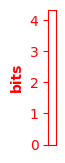

In [10]:
# @title Build and Analyze MSA

# Analysis options
analysis_options = "All Above and Phylogenetic Tree" # @param ["MSA-Only", "All Above and Sequence Logos", "All Above and Phylogenetic Tree", "All Above and Sequence Conservation"]

# Generate dictionary of sequence input string
seqs_dict = input_str_to_dict(input_str)

# Generate list of sequence records from dictionary
seqs = generate_seqs(seqs_dict)

# Generate MSA
print("Generating MSA...")
msa, output_msa_file = generate_msa(seqs)

# Conditional Analysis
if analysis_options == "MSA-Only":
    html = color_msa_by_chemical_composition(msa)
else:
    # Generate list of sequences
    seqs_list = [str(record.seq) for record in msa]

    # Generate sequence logos
    print("Computing Sequence Logos...")
    logo_list = make_all_logos_per_position(seqs_list)

    if analysis_options == "All Above and Sequence Logos":
        # Generate visiualization that combines MSA and SeqLogos
        html = color_msa_seqlogo(msa, 'logo')
    else:
        # Generate phylogenetic tree
        print("Computing Phylogenetic Tree...")
        output_tree_file = generate_phylo_tree(output_msa_file, 'msa.tree')

        # Generate phylogenetic tree
        branches, seq_ids = hack_cladogram(output_tree_file, output_msa_file)

        if analysis_options == "All Above and Phylogenetic Tree":
            # Generate visiualization that combines MSA, Phylo, and SeqLogos
            html = color_msa_seqlogo_phylotree(msa, branches, seq_ids)
        else:
            if analysis_options == "All Above and Sequence Conservation":
                # Generate conservation scores
                conserve_scores, conserve_classes, conserve_scores_rescale, output_conservation_score_file = rate4site('msa.fasta','msa.tree')
                print("Computing Sequence Conservation...")
                html = color_msa_seqlogo_phylotree_conserve(msa, branches, seq_ids, conserve_classes)
            else:
                html = "Please select an analysis option!"

# Output MSA visualization
IPython.display.HTML(html)

# <font color="orange"> **Download Files** </font>

In [7]:
# @title Download MSA file (FASTA format)
if os.path.exists(output_msa_file):
    files.download(output_msa_file)
else:
    print("MSA File not found.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
# @title Download phylogenetic tree file (Newick format)
if analysis_options != "MSA-Only" and analysis_options != "All Above and Sequence Logos":
    if os.path.exists(output_tree_file):
        files.download(output_tree_file)
    else:
        print("Phylognetic tree file not found.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
# @title Download sequence conservation score file (Rate4Site)
if analysis_options == "All Above and Sequence Conservation":
    if os.path.exists(output_conservation_score_file):
        files.download(output_conservation_score_file)
    else:
        print("Sequence conservation score file not found.")